# BEFORE YOU START

* Make sure you have the latest julia, julip, ace, installed
* Change the JULIA_UTILS_PATH in ace_interface.py to point to your castle folder
* Copy the delta_silicon.xyz data to "../data/Si_2018/delta_silicon.xyz"

In [ ]:
from ase.io import read
import numpy as np
import sys
from matplotlib import pyplot as plt

import joblib
import pickle
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, ASEMLCalculator, AceGlobalRepresentation, train_linear_model
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

%load_ext autoreload
%autoreload 2

# Load structures

In [2]:
# Load xyz data
input_file =  "../data/Si_2018/delta_silicon.xyz"
input_file =  "../data/Si_2018/delta_silicon.xyz"

frames_ = read(input_file, index = ':')
    
# Wrap positions so rascal does not complain
for ff in frames_:
    ff.wrap(eps=1e-11)
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'

In [3]:
tags = set()
for ff in frames_:
    tags.add(ff.info['config_type'])
print(tags)

{'sh', 'isolated_atom', 'divacancy', 'liq', 'hex_diamond', 'dia', 'bc8', 'surface_110', 'decohesion', 'fcc', 'crack_111_1-10', 'bt', 'amorph', 'interstitial', '111adatom', 'vacancy', 'surface_001', 'hcp', 'surface_111_pandey', 'bcc', 'surface_111', 'crack_110_1-10', 'sp2', 'st12', 'surface_111_3x3_das', 'sp', 'screw_disloc'}


In [8]:
frames = []
for ff in frames_:
    # if ff.info['config_type'] in ['amorph', 'bt', 'dia', 'liq', 'fcc', 'bcc', 'hcp', 'hex_diamond']:
    try:
        len(ff.info['dft_virial'])
        frames.append(ff)
    except KeyError:
        pass

# Build a model

Compute representation

In [9]:
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
s_val = get_virials(val_frames, virial_name)
nat_val = get_nat(val_frames)

N = 5               # Body order
maxdeg = 10         # Maximum degree of angular and radial expansion
rcut = 5.0          # Radial Cutoff
r0 = 1.0            # Lowest radius for basis
reg = 1e-8          # Ridge regularizer
species = 14        # Atomic number of species present


representation = AceGlobalRepresentation(N, maxdeg, rcut, species, r0, reg, 
                                         energy_name=energy_name, force_name=force_name, virial_name=virial_name)

In [10]:
# #  compute features
features = representation.transform(frames)
# #  save them
dump(input_file[:-4] + "_features.xz", features)

## Train a linear model

In [27]:
# load the features
# features = load(input_file[:-4] + "_features.xz")
noise = 1e-6
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model_linear = train_linear_model(tr_features, noise, e_t, f_t)

MAE=0.077 RMSE=0.500 SUP=0.722 R2=-0.081
MAE=0.263 RMSE=0.636 SUP=21.136 R2=0.565


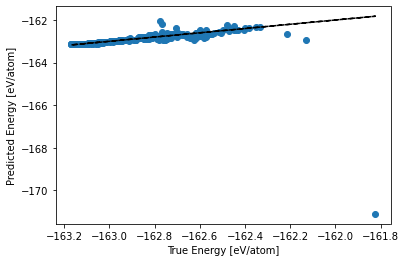

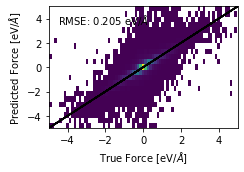

In [28]:
# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model_linear.predict_energy(val_features)
fp = model_linear.predict_forces(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.205 eV/$\AA$')
plt.tight_layout()
plt.savefig("../../plots/Si_linear.png", dpi=400)

## train an ensemble of linear models

In [10]:
# features = load(input_file[:-4] + "_features.xz")

MAE=0.012 RMSE=0.023 SUP=0.101 R2=0.988
MAE=0.101 RMSE=0.292 SUP=14.064 R2=0.863


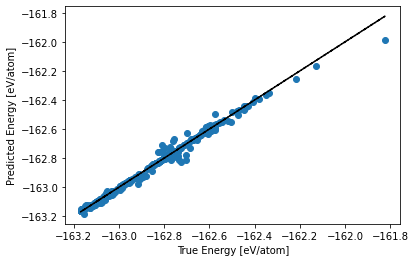

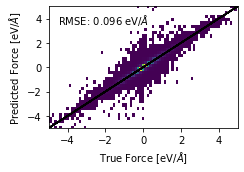

In [64]:
noise = 1e-8
n_clusters = 8
n_neighbours = 1
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model_ens_1 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model_ens_1.predict_energy(val_features)
fp = model_ens_1.predict_forces(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.096 eV/$\AA$')
plt.tight_layout()
plt.savefig("../../plots/Si_ensemble.png", dpi=400)

45.10397669198578
1670.2608311650695
197.12040936842757
54.4980227892758
1582.509525308839
163.4534171218137
229.68765930620032
40.7735042520329


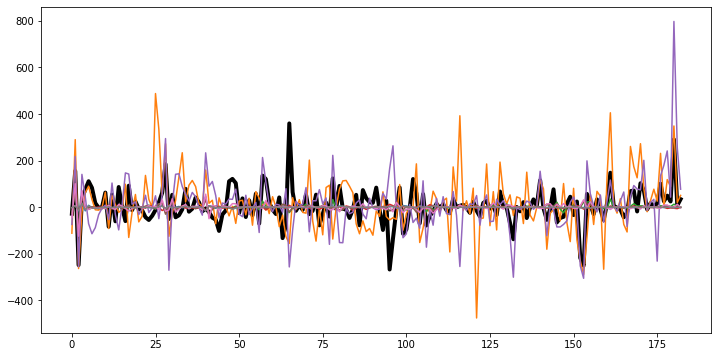

In [68]:
plt.figure(figsize = (12, 6))
plt.plot(model_linear.weights, 'k-', lw = 4)
for n in model_ens_1.potentials.keys():
    plt.plot(model_ens_1.potentials[n].weights)
    print(np.linalg.norm(model_ens_1.potentials[n].weights))
plt.show()

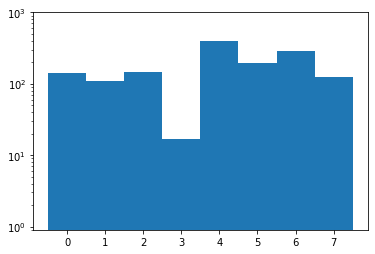

In [67]:
plt.hist(model_ens_1.train_labels, bins = np.linspace(-0.5, n_clusters - 0.5, n_clusters+1))
plt.yscale('log')
plt.ylim(9e-1, 1000)
plt.show()

Using 9 clusters
MAE=0.012 RMSE=0.022 SUP=0.101 R2=0.989
MAE=0.120 RMSE=1.002 SUP=99.402 R2=0.383


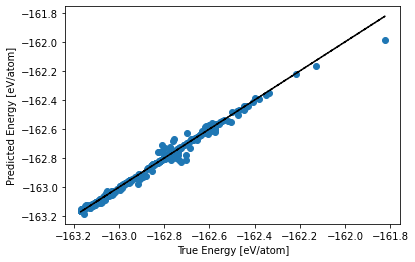

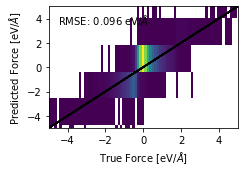

In [26]:
noise = 1e-8
n_clusters = 'auto'
n_neighbours = 10
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.096 eV/$\AA$')
plt.tight_layout()
plt.savefig("../../plots/Si_ensemble.png", dpi=400)

7
7
7
7
7
7
7
7
7
MAE=0.005 RMSE=0.011 SUP=0.051 R2=0.998
MAE=0.045 RMSE=0.094 SUP=1.307 R2=0.967


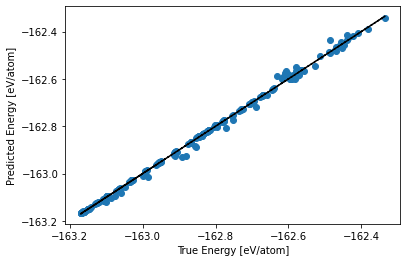

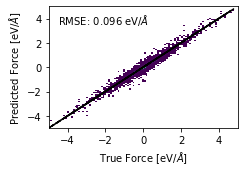

In [20]:

# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.text(-4.5, 3.5, 'RMSE: 0.096 eV/$\AA$')
plt.tight_layout()


In [15]:
# # save the model
# dump('./model.xz',model)

# use the model for cell optimization

In [16]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter

In [17]:
# model = load('./model.xz')

In [18]:
calc = ASEMLCalculator(model, model.representation)

In [24]:
latticeconstant = 4.5
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-4)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(), enRef, volRef**(1/3)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:21:37    -1270.022499*       0.0000


(Cell([4.5, 4.5, 4.5]), array([-1270.02249948]), 4.499999999999999)